# into my eyes

In [1]:
from collections import Counter, defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import openpyxl
from captum.attr import visualization
from tqdm import tqdm


In [2]:
from erisk import metrics

In [3]:
def rescale(v, method):
    a = np.array(v)
    match method:
        case "prob":
            a = (a - a.min()) / (a.max() - a.min())
        case "softmax":
            a = np.exp(a) / sum(np.exp(a))
        case "std":
            a = (a - a.mean()) / (a.std())
        case _:
            print(f'"{rescale}" is ignored because is not a supported rescale method')
    return a

def md_rescale(A, method):
    return np.array([rescale(a, method) for a in A])

In [4]:
def plot_vdr(tokens_list: list[list], scores_list: list[list]):
    vis_data_records = list()
    for tokens, scores in zip(tokens_list, scores_list):
        vdr = visualization.VisualizationDataRecord(
            pred_prob=0.68,  # (Predicted Label)
            pred_class="depress",  # Predicted Label
            word_attributions=a,
            true_class="depress",  # True Label, ground-truth label of the input
            attr_class="*",  # Attribution Label, the input
            attr_score=a.sum(),  # Attribution Score, the sum of IG accross the whole tokens
            raw_input_ids=tokens,  # the list of tokens
            convergence_score=0,  # the difference between approximated and true integrated gradients
        )
        vis_data_records.append(vdr)
    visualization.visualize_text(vis_data_records)


## datasets

Loading and mergin dataset

In [5]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(
        Path("datasets", "task_0", f"{filename}.tsv"), "rt", encoding="utf8"
    ) as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")

splitting the dataset in training and testing (following previous works)

In [6]:
# lookup = df.set_index("old_idx")["new_idx"]
# pth = Path("datasets", "task_0", "train_test_splitting.json")
# idx = json.load(open(pth, "rt"))
# idx = {k: [lookup[i] for i in lst if i in lookup] for k, lst in idx.items()}

In [7]:
# x, y = df["raw_text"], df["label"]
# x_train, x_test = x.loc[idx["train"]], x.loc[idx["test"]]
# y_train, y_test = y.loc[idx["train"]].astype(int), y.loc[idx["test"]].astype(int)

loading psycologist highlights

In [8]:
wb = openpyxl.load_workbook('datasets/task_0/Testset.xlsx')
sheet = wb.active

In [9]:
yellow, no_highlight = list(), list()

In [10]:
for row in range(2, 1105):
    uid = sheet[f"A{row}"].value
    text = sheet[f"B{row}"].value
    pattern = sheet[f"C{row}"].value
    if pattern is not None and pattern.strip():
        yellow.append((uid, text, pattern))
    else:
        no_highlight.append((uid, text))

In [11]:
df_yellow = pd.DataFrame(yellow, columns=["excel_idx", "text", "pattern"])
df_val = pd.merge(df, df_yellow, left_on="raw_text", right_on="text")
df = df.loc[~df.new_idx.isin(df_val.new_idx)] # remove val

In [12]:
X, y = df["pp_text"], df.label.astype(int)

pattern borders

In [13]:
import re
resp = r"\, |\. |\; |\: |\! |\? |\.|  | \<|\> |I "

In [14]:
pattern_boundaries = defaultdict(list)
for i, row in df_yellow.iterrows():
    text_bites = [
        v.strip().strip() for v in re.split(resp, row["pattern"]) if v.strip().strip()
    ]
    for bit in text_bites:
        istart = row["text"].lower().find(bit.lower())
        if istart != -1:
            istop = istart + len(bit)
            pattern_boundaries[row.excel_idx].append((istart, istop))
        # else:
        #     print(bit)
        #     print(row["text"])


In [15]:
for k, l in pattern_boundaries.items():
    i = 0
    while i < len(l) - 1:
        if l[i + 1][0] - l[i][1] < 7:
            l[i] = (l[i][0], l[i + 1][1])
            del l[i + 1]
        else:
            i += 1
    pattern_boundaries[k] = l


## models

### bornrule

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from bornrule import BornClassifier

In [17]:
vect = TfidfVectorizer()
tfidf_mx = vect.fit_transform(X).toarray()
words = vect.get_feature_names_out()

In [18]:
W = words.shape[0]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_mx,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [20]:
amplitude = 0.5 #amplitude
balance = 1 #balance
entropy = 1 #entropy

In [21]:
born = BornClassifier(a=amplitude, b=balance, h=entropy)
born.fit(X=X_train, y=y_train)

BornClassifier(b=1, h=1)

In [22]:
y_hat = born.predict(X_test)
metrics(y_hat, y_test)

F1: 0.78
Precision: 0.66
Recall: 0.95


In [23]:
born.classes_

array([0, 1])

In [24]:
weights = born.explain()[:,1]
scores = sorted(list(zip(words, weights)), key = lambda x : x[-1], reverse=True)
kwscores = defaultdict(float, scores)

let's see locally

In [25]:
yellow_born = vect.transform(df_val.pp_text).toarray()

In [26]:
born_tokens, born_scores, born_idx = list(), list(), list()
for idx, v in tqdm(enumerate(yellow_born)):
    sample = v.reshape((1, W))
    weights = born.explain(sample)[:, 1]
    scores = sorted(list(zip(words, weights)), key=lambda x: x[-1], reverse=True)
    kwscores = defaultdict(float, scores)

    tokens = df_val.loc[idx, "pp_text"].split()
    scores = np.array([kwscores[w] for w in tokens])

    born_tokens.append(tokens)
    born_scores.append(scores)
    born_idx.append(df_val.loc[idx].excel_idx)

161it [00:04, 35.34it/s]


In [27]:
born_scores = md_rescale(born_scores, "prob")

C:\Users\martin.ranieri\AppData\Local\Temp\ipykernel_10088\2425028137.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([rescale(a, method) for a in A])


In [28]:
# plot_vdr(born_tokens, born_scores)

### RoBERTa

In [29]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050'

In [30]:
from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
)
from datasets import load_dataset
import datasets

In [31]:
tokenizer_hf = AutoTokenizer.from_pretrained("ShreyaR/finetuned-roberta-depression")
model = AutoModelForSequenceClassification.from_pretrained("ranieri-unimi/test-trainer")

In [32]:
rob_scores, rob_tokens, rob_idx= list(), list(), list()
for idx, text in tqdm(df_val.raw_text.items()):
    input_ids = tokenizer_hf.encode(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(
        input_ids,
        output_attentions=True,
        # attention_mask=attention_mask,
    )
    attention_weights = outputs[-1]
    attention_norms = attention_weights[-1][0, :, :, :].norm(dim=0)
    scores = attention_norms[0, 1:-1].cpu().detach().numpy()
    tokens = [tokenizer_hf.decode(e).lower().strip() for e in input_ids[0, 1:-1]]

    rob_scores.append(scores)
    rob_tokens.append(tokens)
    rob_idx.append(df_val.loc[idx].excel_idx)

161it [00:56,  2.83it/s]


In [33]:
rob_scores = md_rescale(rob_scores, "std")
rob_scores = md_rescale(rob_scores, "softmax")
rob_scores = md_rescale(rob_scores, "softmax")
rob_scores = md_rescale(rob_scores, "softmax")
# very aggressive

C:\Users\martin.ranieri\AppData\Local\Temp\ipykernel_10088\2425028137.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([rescale(a, method) for a in A])


In [34]:
# plot_vdr(rob_tokens, rob_scores)

### spike

moving average

In [140]:
N = 5
rolling_weights = np.ones(N) / N  # uniform
rolling_weights = np.array([1, 3, 6, 3, 1]) / 14


<AxesSubplot: >

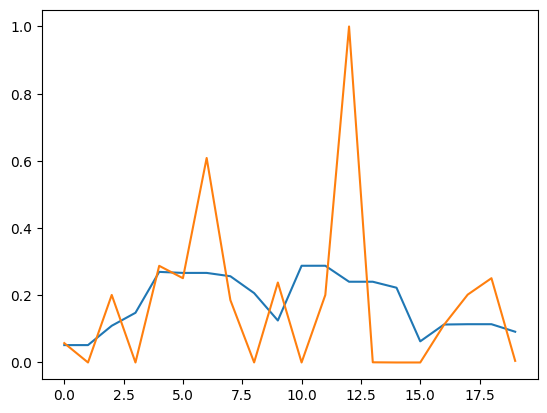

In [118]:
# sns.lineplot(raw_scores)
# sns.lineplot(smooth_scores)

In [141]:
born_matches = defaultdict(lambda : False)

for raw_scores, tokens, excel_idx in zip(born_scores, born_tokens, born_idx):
    smooth_scores = np.convolve(raw_scores, rolling_weights, mode="same")
    eigen_word = tokens[smooth_scores.argmax()]
    text = df_yellow.set_index("excel_idx").loc[excel_idx, "text"]
    eigen_idx = text.find(eigen_word)

    has_matched = False
    for start, end in pattern_boundaries[excel_idx]:
        if start < eigen_idx < end:
            born_matches[excel_idx] = True
            continue
        
sum(born_matches.values()) / len(born_idx)  

0.5527950310559007

In [142]:
rob_matches = defaultdict(lambda : False)

for raw_scores, tokens, excel_idx in zip(rob_scores, rob_tokens, rob_idx):
    smooth_scores = np.convolve(raw_scores, rolling_weights, mode="same")
    eigen_word = tokens[smooth_scores.argmax()]
    text = df_yellow.set_index("excel_idx").loc[excel_idx, "text"]
    eigen_idx = text.find(eigen_word)

    has_matched = False
    for start, end in pattern_boundaries[excel_idx]:
        if start < eigen_idx < end:
            rob_matches[excel_idx] = True
            continue
        
sum(rob_matches.values()) / len(rob_idx)

0.34782608695652173

meanshift